## Imports

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import sparse
import os
import copy
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
from skimage.transform import rotate

## Load from Data storage path into data_argo

In [2]:
data_path = os.path.join('../LaneGCN/', "dataset","preprocess", "val_crs_dist6_angle90.p")
data_argo = np.load(data_path, allow_pickle=True)

## Check keys in data_argo['idx']

In [3]:
idx = 50
for keys,_ in data_argo[idx].items():
    print(keys)

idx
city
feats
ctrs
orig
theta
rot
gt_preds
has_preds
graph


## Check keys in data_argo['idx']['graph']

In [4]:
for k,v in data_argo[idx]['graph'].items():
    print(k)

ctrs
num_nodes
feats
turn
control
intersect
pre
suc
lane_idcs
pre_pairs
suc_pairs
left_pairs
right_pairs
left
right


## Check size of object related keys

In [5]:
print("Idx: ", data_argo[idx]['idx'])
print("City: ", data_argo[idx]['city'])
print("Number of agents in scene: ", data_argo[idx]['feats'].shape[0], "\n")

print('Feats: ', data_argo[idx]['feats'].shape)
print('Centers at step 20 of agents: ', data_argo[idx]['ctrs'].shape)
print('Orig of target agent at step 20: ', data_argo[idx]['orig'], "\n")

print('Theta (Initial Orientation at step1-0): ', data_argo[idx]['theta'])
print('Rot matrix 2d: ', data_argo[idx]['rot'], "\n")

print('Ground truth predictions: ', data_argo[idx]['gt_preds'].shape)
print('Ground truth prediction masks: ', data_argo[idx]['has_preds'].shape)

Idx:  50
City:  MIA
Number of agents in scene:  12 

Feats:  (12, 20, 3)
Centers at step 20 of agents:  (12, 2)
Orig of target agent at step 20:  [ 582.5992 1438.9241] 

Theta (Initial Orientation at step1-0):  1.6114140464436029
Rot matrix 2d:  [[-0.04060655 -0.9991752 ]
 [ 0.9991752  -0.04060655]] 

Ground truth predictions:  (12, 30, 2)
Ground truth prediction masks:  (12, 30)


## Check graph related keys

In [6]:
print("Ctrs: ", data_argo[idx]['graph']['ctrs'].shape)
print("Num nodes: ", data_argo[idx]['graph']['num_nodes'])
print("Feats: ", data_argo[idx]['graph']['feats'].shape)
print("Turning or not marker: ", data_argo[idx]['graph']['turn'].shape)
print("Control marker: ", data_argo[idx]['graph']['control'].shape)
print("Intersection marker: ", data_argo[idx]['graph']['intersect'].shape, "\n")


print("Lane-ids: ", data_argo[idx]['graph']['lane_idcs'].shape)
print("Pre: ", len(data_argo[idx]['graph']['pre']), "This contains 6 levels of predecssor relations as u-v")
print("Suc: ", len(data_argo[idx]['graph']['suc']), "This contains 6 levels of successor relations as u-v")
print("Left: ", len(data_argo[idx]['graph']['left']), "This contains left relations as u-v")
print("Right: ", len(data_argo[idx]['graph']['right']), "This contains right relations as u-v", "\n")


print("Pre-pairs: ", len(data_argo[idx]['graph']['pre_pairs']))
print("Suc-pairs: ", len(data_argo[idx]['graph']['suc_pairs']))
print("Left-pairs: ", len(data_argo[idx]['graph']['left_pairs']))
print("Right-pairs: ", len(data_argo[idx]['graph']['right_pairs']))

Ctrs:  (1296, 2)
Num nodes:  1296
Feats:  (1296, 2)
Turning or not marker:  (1296, 2)
Control marker:  (1296,)
Intersection marker:  (1296,) 

Lane-ids:  (1296,)
Pre:  6 This contains 6 levels of predecssor relations as u-v
Suc:  6 This contains 6 levels of successor relations as u-v
Left:  2 This contains left relations as u-v
Right:  2 This contains right relations as u-v 

Pre-pairs:  150
Suc-pairs:  150
Left-pairs:  92
Right-pairs:  34


## For example, what do left connections look like

In [7]:
data_argo[idx]['graph']['left']

{'u': array([ 243,  244,  245,  246,  247,  248,  249,  250,  251,  351,  352,
         353,  354,  355,  356,  357,  358,  359,  369,  370,  371,  372,
         373,  374,  375,  376,  377,  378,  379,  380,  381,  382,  383,
         384,  385,  386,  387,  388,  389,  390,  391,  392,  393,  394,
         395,  441,  442,  443,  444,  445,  446,  447,  448,  449,  468,
         469,  470,  471,  472,  473,  474,  475,  476,  576,  577,  578,
         579,  580,  581,  582,  583,  584,  594,  595,  596,  597,  598,
         599,  600,  601,  602,  603,  604,  605,  606,  607,  608,  609,
         610,  611,  648,  649,  650,  651,  652,  653,  654,  655,  656,
         666,  667,  668,  669,  670,  671,  672,  673,  674,  684,  685,
         686,  687,  688,  689,  690,  691,  692,  711,  712,  713,  714,
         715,  716,  717,  718,  719,  729,  730,  731,  732,  733,  734,
         735,  736,  737,  765,  766,  767,  768,  769,  770,  771,  772,
         773,  774,  775,  776,  

# Example: How to visualize a torch-geometric graph

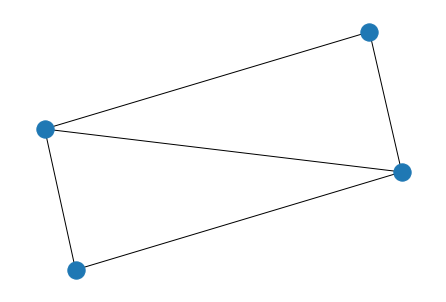

In [8]:
import networkx as nx
import torch_geometric
edge_index = torch.tensor([[0, 1, 1, 2, 2, 0, 3, 2, 3, 1],
                           [1, 0, 2, 1, 0, 2, 2, 3, 1, 3]], dtype=torch.long)
x = torch.tensor([[-2], [-1], [1], [2]], dtype=torch.float)

data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

## Visualize data_argo['idx']['graph']

2*Total pairs:  362


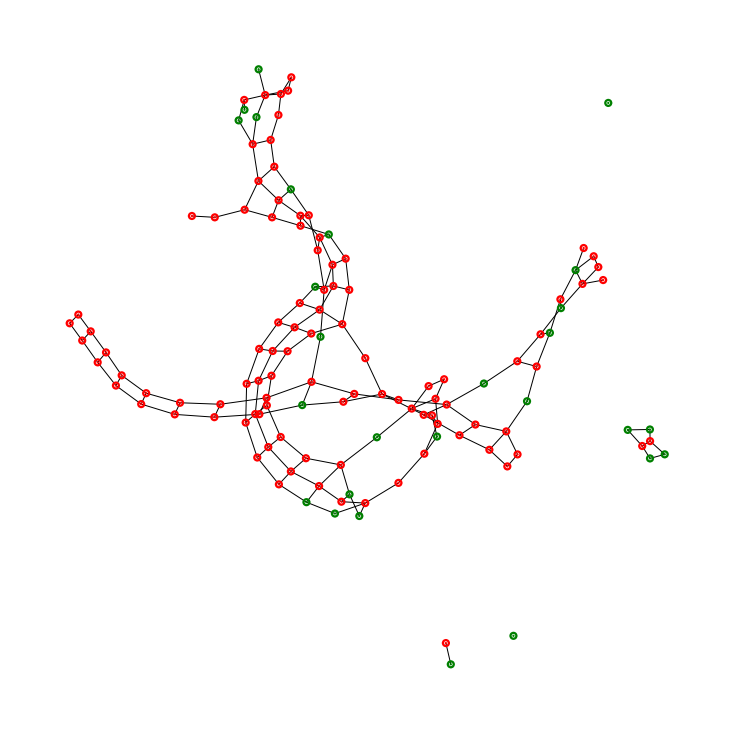

In [9]:
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx

idx = 500
# Get total adjacency matrix
total_pairs = np.concatenate([data_argo[idx]['graph']['pre_pairs'], 
                             data_argo[idx]['graph']['suc_pairs'],
                             data_argo[idx]['graph']['left_pairs'],
                             data_argo[idx]['graph']['right_pairs']], 0)

print('2*Total pairs: ', len(total_pairs))

# Edge tensor and actual data tensor
edge_index = torch.tensor(np.concatenate([total_pairs, 
                                          np.fliplr(total_pairs)], 
                                         0), dtype=torch.long).t().contiguous()
x = torch.tensor(np.unique(total_pairs), dtype=torch.float) # node numbers

# Feed into torch geometric
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
# Convert to networkx
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

# Visualize 
color_map = []
for node in g:
    if data_argo[idx]['graph']['intersect'][node]>0:
        color_map.append('red')
    else: 
        color_map.append('green')
color_map = np.array(color_map)
plt.figure(1,figsize=(10,10)) 
nx.draw(g, cmap=plt.get_cmap('Set1'),node_size=5,node_color=color_map, linewidths=6)
plt.show()